# **Experiment:** The structure of the solution set

This notebook reproduces the results of the numerical experiments in

> C. Arrieta and C. A. Sing Long, "*Exact Local Recovery for Chemical Shift Imaging*."

You can use the following code to cite our work.
```bibtex
@article{arrieta_exact_2025, 
  title   = {Exact Local Recovery for Chemical Shift Imaging},  
  author  = {Arrieta, Cristóbal and Sing Long, Carlos A.}, 
  date    = {2025-03-31}
}
```

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from matplotlib.transforms import Bbox

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

In [2]:
# layout for plots
PLT_LAYOUT = 'constrained'
BBOX_INCHES = Bbox([ [0, 0], [6, 6] ])
def savefig(fname):
  plt.savefig(f'FIG/E01_{fname:s}.png', bbox_inches=BBOX_INCHES, dpi=300)
  plt.savefig(f'FIG/E01_{fname:s}.eps', bbox_inches=BBOX_INCHES)

## Contents

1. [Loading the data](#loading-the-data)
2. [Submatrices of the model matrix](#submatrices-of-the-model-matrix)
3. [Solution set when the concentrations are known](#solution-set-when-the-concentrations-are-known)
4. [Solution set](#the-solution-set)
5. [Swaps](#swaps)
6. [Figures](#figures)

## Loading the data

For these experiments we choose echo times of the form
$$
  t_k = t_0 + \Delta t k \quad\text{for}\quad k\in\{0,\ldots, n_e - 1\}.
$$
To be concrete, we select
$$
  t_0 = 1.3\text{ms}\quad\text{and}\quad \Delta t = 1.05\text{ms}.
$$

In [164]:
# initial time
to = 0.001300
# time step
dte = 0.001050
# number of echos
ne = 4
# echo times
te = to + dte * np.linspace(0, ne-1, ne)

In [165]:
print(f'Echo times and echo spacing')
for I in range(ne):
  if I > 0:
    print(f'   Echo time {I:2d} : {te[I]:.9f} s  (Interval : {te[I] - te[I-1]:.9f} s)')
  else:
    print(f'   Echo time {I:2d} : {te[I]:.9f} s')

Echo times and echo spacing
   Echo time  0 : 0.001300000 s
   Echo time  1 : 0.002350000 s  (Interval : 0.001050000 s)
   Echo time  2 : 0.003400000 s  (Interval : 0.001050000 s)
   Echo time  3 : 0.004450000 s  (Interval : 0.001050000 s)


We can then assemble the model matrix for different sets of chemical species. Here we consider water and fat, and water, fat and silicone.

In [166]:
from CSITools.routines.models import get_wf_model, get_wfsilicone_model
from CSITools.routines.models import assemble_model_matrix

In [167]:
# number of species 
#   2 for water/fat
#   3 for water/fat/silicone
ns = 2
# field for the model (in T)
field = 3
if ns == 2:
  # signal parameters
  cshifts, cweights = get_wf_model(field)
if ns == 3:
  # signal parameters
  cshifts, cweights = get_wfsilicone_model(field)
# model matrix
M = assemble_model_matrix(te, cshifts, cweights)

print(f'Model matrix')
print(f'   Size                : {M.shape[0]} x {M.shape[1]}')
print(f'   Singular values')
print(f'    - Maximum          : {np.linalg.svdvals(M)[0]:.3f}')
print(f'    - Minimum          : {np.linalg.svdvals(M)[-1]:.3f}')

Model matrix
   Size                : 4 x 2
   Singular values
    - Maximum          : 2.128
    - Minimum          : 1.863


## Submatrices of the model matrix

Assume that $n_e \geq n_s$. Verifying each $n_s\times n_s$ submatrix of the model matrix $\boldsymbol{\Phi}$ is computationally intractable for $n_s, n_e \gg 1$. However, for small values we can verify this by direct computation.

In [168]:
from itertools import combinations

tsubsets = list(combinations(set([ I for I in range(ne) ]), ns))

print(f'Verify that ns x ns submatrices are non-singular.')
svmin = np.inf
for tsubset in tsubsets:
  print(' Rows : ', tsubset)
  MS = M[list(tsubset)]
  svmin_MS = np.linalg.svdvals(MS).min()
  svmin = np.minimum(svmin, svmin_MS)
  print(f'  Minimum singular value : {svmin_MS:.6f}')
print(f'Minimum singular value over all subsets: {svmin:.6f}')

Verify that ns x ns submatrices are non-singular.
 Rows :  (0, 1)
  Minimum singular value : 1.313247
 Rows :  (0, 2)
  Minimum singular value : 0.275383
 Rows :  (0, 3)
  Minimum singular value : 1.093040
 Rows :  (1, 2)
  Minimum singular value : 1.313247
 Rows :  (1, 3)
  Minimum singular value : 0.275383
 Rows :  (2, 3)
  Minimum singular value : 1.313247
Minimum singular value over all subsets: 0.275383


## Solution set when the true concentrations are known

If the true concentrations $\boldsymbol{c}_0$ are known then
$$
  (\xi_0 + \eta, \boldsymbol{c}_0) \in \mathcal{S}(\boldsymbol{s}_0)
$$
if and only if
$$
  k\in \operatorname{supp}(\tilde{\boldsymbol{s}}_0):\,\, e^{2\pi i \eta t_k} = 1
$$
where $\tilde{\boldsymbol{s}}_0 = \boldsymbol{\Phi}\boldsymbol{c}_0$. The solutions to the above system depend only on
$$
  \tilde{S}_0 = \operatorname{supp}(\tilde{\boldsymbol{s}}_0).
$$

In [169]:
def W(xi):
  return np.diag(np.exp(2 * np.pi * 1j * te * xi))

Although we can select the support at random, we present the results for the full support to compare the results.

In [170]:
# fraction
delta = 1.0
# support
So = np.where(np.random.rand(ne) <= delta)[0]
while np.sum(So) == 0:
  So = np.where(np.random.rand(ne) <= delta)[0]

nso = So.size

print('Support: ', *So)

Support:  0 1 2 3


We can visualize the distance
$$
  \eta \mapsto \|\boldsymbol{W}(\eta) - \boldsymbol{I}\|_F = \sqrt{\sum\nolimits_{k\in \tilde{S}_0} |1 - e^{2\pi i \eta t_k}|^2}.
$$

In [171]:
# sampling points for field
num_f = 5000
# maximum value for field (Hz)
f_max = 2500
# sampling points for r2*
num_r = 256
# maximum value for r2* (Hz)
r_max = 25
# values
f = np.linspace(-f_max, +f_max, num_f)
r = np.linspace(-0.0, +r_max, num_r)
# mesh
[ mf, mr ] = np.meshgrid(f, r)
# values
mxi = mf + 1j * mr

In [172]:
E = np.linalg.norm((np.exp(2 * np.pi * 1j * np.outer(mxi.ravel(), te)) - 1.0)[:, So], axis=1).reshape(mxi.shape)
Ef = np.linalg.norm((np.exp(2 * np.pi * 1j * np.outer(f.ravel(), te)) - 1.0)[:, So], axis=1).reshape(f.shape)

# save data
np.savez_compressed(f'DAT/E01_E_FULL_NE{ne}_NS{ns}.npz', te=te, f=f, r=r, So=So, E=E, Ef=Ef)

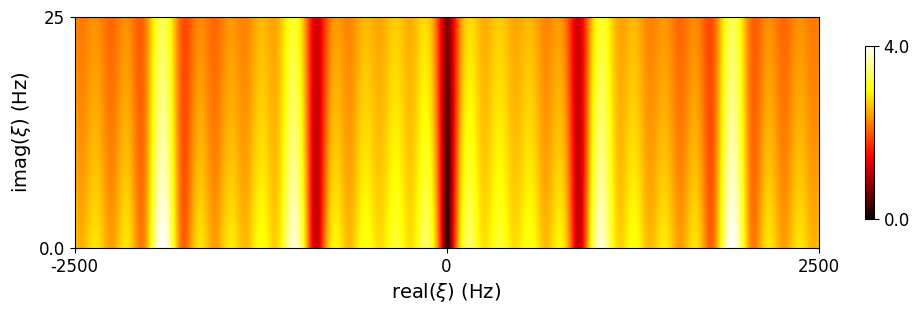

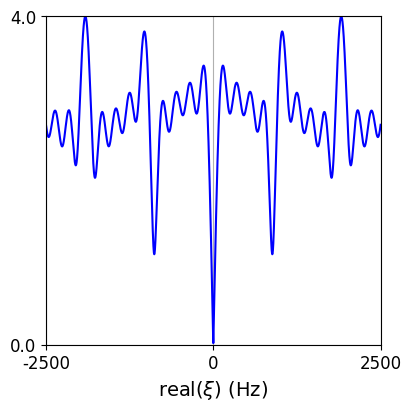

In [173]:
xticks = [ 0, num_f // 2, num_f - 1 ]
yticks = [ 0, num_r - 1 ]
xtick_labels = [ f'{-int(f_max):d}', '0', f'{+int(f_max):d}' ]
ytick_labels = [ '0.0', f'{int(r_max):d}' ]

plt.figure(figsize=(12, 3))
plt.imshow(E, origin='lower', vmin=0.0, cmap='hot', aspect='auto')
plt.xlim([ 0, num_f - 1 ])
plt.ylim([ 0, num_r - 1 ])
plt.xticks(xticks, labels=xtick_labels, fontsize=12)
plt.yticks(yticks, labels=ytick_labels, fontsize=12)
plt.xlabel('real($\\xi$) (Hz)', fontsize=14)
plt.ylabel('imag($\\xi$) (Hz)', fontsize=14)
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1f}', ticks=[ 0.0, E.max() ]).ax.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(4, 4), layout='constrained')
plt.plot(f, Ef, color='b')
plt.xlim([ f.min(), f.max() ])
plt.ylim([ 0.0, Ef.max() ])
plt.xticks([ f.min(), 0, f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([0.0, Ef.max() ], labels=[ '0.0', f'{Ef.max():.1f}'], fontsize=12)
plt.xlabel('real($\\xi$) (Hz)', fontsize=14)
plt.grid('both')
plt.show()

When the echo times are rational factors of each other, the system allows for non-zero solutions. Typically, due to numerical rounding, this will be the case. Let
$$
  t_{\max} = \max\{t_k:\, k\in \tilde{S}_0\}.
$$
We compute first the rational representations
$$
  \frac{t_k}{t_{\max}} = \frac{p_k}{q_k}\quad p_k,q_k\in \mathbb{N},\quad k\in \tilde{S}_0. 
$$
We use the least common multiple to represent them with the same *numerator*, i.e., if
$$
  p = \operatorname{lcm}(p_1,\ldots, p_{n_e})
$$
then we write
$$
  \frac{t_k}{t_{\max}} = \frac{p}{q_k p / p_{k}}.
$$
The solution to the system
$$ 
  k\in\tilde{S}_0:\quad e^{2\pi i \eta t_{k}} = 1
$$
must satisfy
$$
  \eta t_{\max} p \in \bigcap_{k=1}^{n_e} \frac{q_k p}{p_k} \mathbb{Z}.
$$
However,
$$
  \bigcap_{k=1}^{n_e}\frac{q_k p}{p_k} \mathbb{Z} = q\mathbb{Z}\quad\text{for}\quad q = \operatorname{lcm}\left(\left\{\frac{q_k p}{p_k}:\, k\in\tilde{S}_0\right\}\right)
$$
whence
$$
  \eta \in \frac{1}{t_{\max}} \frac{q}{p}\mathbb{Z}.
$$
In particular, the set is *real*.

In [174]:
import sympy

p_te = np.zeros((nso,), dtype=int)
q_te = np.zeros((nso,), dtype=int)

for I, _k in enumerate(So):
  (p, q) = sympy.nsimplify(te[_k] / te[So].max()).as_numer_denom()
  print(f' Index {I} | Support {_k} | Ratio: {te[_k] / te[So].max():.3E} | (p, q): ({p}, {q})')
  p_te[I] = p
  q_te[I] = q

lcm_p_te = sympy.lcm(p_te[::-1])
lcm_qp_te = sympy.lcm(q_te[::-1] * (lcm_p_te // p_te))
sZ_step = (1/te[So].max()) * float(lcm_qp_te / lcm_p_te)

print('Error of rational approximation  : ', (te[So].max() * p_te.astype('float') / q_te.astype('float') - te[So]).max())
print('lcm(p_k)                         : ', lcm_p_te)
print("lcm(q_k p / p_k)                 : ", lcm_qp_te)
print("Step of solution set             : ", sZ_step)

 Index 0 | Support 0 | Ratio: 2.921E-01 | (p, q): (26, 89)
 Index 1 | Support 1 | Ratio: 5.281E-01 | (p, q): (47, 89)
 Index 2 | Support 2 | Ratio: 7.640E-01 | (p, q): (68, 89)
 Index 3 | Support 3 | Ratio: 1.000E+00 | (p, q): (1, 1)
Error of rational approximation  :  4.336808689942018e-19
lcm(p_k)                         :  41548
lcm(q_k p / p_k)                 :  3697772
Step of solution set             :  20000.0


We can verify these are indeed elements in $S_W$.

In [175]:
fW = np.linspace(-10, 10, 21) * sZ_step
fW = np.round(fW, decimals=8)

EfW = np.array([ np.linalg.norm(np.exp(2 * np.pi * 1j * _f * te[So]) - 1.0) for _f in fW ])

for _f, _Ef in zip(fW, EfW):
  print(f'Frequency (Hz) : {_f:+.3E} | Error : {_Ef:.3E}')

Frequency (Hz) : -2.000E+05 | Error : 1.303E-12
Frequency (Hz) : -1.800E+05 | Error : 3.364E-13
Frequency (Hz) : -1.600E+05 | Error : 5.575E-13
Frequency (Hz) : -1.400E+05 | Error : 7.371E-13
Frequency (Hz) : -1.200E+05 | Error : 4.547E-13
Frequency (Hz) : -1.000E+05 | Error : 6.517E-13
Frequency (Hz) : -8.000E+04 | Error : 2.788E-13
Frequency (Hz) : -6.000E+04 | Error : 2.274E-13
Frequency (Hz) : -4.000E+04 | Error : 1.394E-13
Frequency (Hz) : -2.000E+04 | Error : 6.969E-14
Frequency (Hz) : +0.000E+00 | Error : 0.000E+00
Frequency (Hz) : +2.000E+04 | Error : 6.969E-14
Frequency (Hz) : +4.000E+04 | Error : 1.394E-13
Frequency (Hz) : +6.000E+04 | Error : 2.274E-13
Frequency (Hz) : +8.000E+04 | Error : 2.788E-13
Frequency (Hz) : +1.000E+05 | Error : 6.517E-13
Frequency (Hz) : +1.200E+05 | Error : 4.547E-13
Frequency (Hz) : +1.400E+05 | Error : 7.371E-13
Frequency (Hz) : +1.600E+05 | Error : 5.575E-13
Frequency (Hz) : +1.800E+05 | Error : 3.364E-13
Frequency (Hz) : +2.000E+05 | Error : 1.

## Structure of the solution set

If we let $\boldsymbol{s}_0 = \boldsymbol{W}(\xi_0) \boldsymbol{\Phi}\boldsymbol{c}_0$ then the *solution set* $\mathcal{S}(\boldsymbol{s}_0)$ is the set
$$
  \mathcal{S}(\boldsymbol{s}_0) = \{(\xi, \boldsymbol{c}):\,\,\boldsymbol{s}_0 = \boldsymbol{W}(\xi) \boldsymbol{\Phi}\boldsymbol{c} \}.
$$
It is clear that
$$
  (\xi_0, \boldsymbol{c}) = \mathcal{S}(\boldsymbol{s}_0). 
$$
The structure of the solution set is closely related to that of the values of $\eta$ for which
$$
  \boldsymbol{\Delta}(\eta) = \begin{bmatrix} \boldsymbol{W}(\eta)\boldsymbol{\Phi} & \boldsymbol{\Phi} \end{bmatrix}
$$
has non-trivial kernel. Let
$$
  Z_{\Delta} = \{\eta\in \mathbb{C}:\,\, \text{$\operatorname{ker}(\boldsymbol{\Delta}(\eta))$ is non-trivial}\}.
$$

In [176]:
def Delta(eta):
  return np.hstack([ W(eta) @ M, M ])

def svmin_Delta(eta):
  return np.linalg.svdvals(Delta(eta)).min()

We can plot the minimum singular value of $\boldsymbol{\Delta}$ to determine the set $Z_{\Delta}$.

In [177]:
# sampling points for field
num_f = 5000
# maximum value for field (Hz)
f_max = 1500
# sampling points for r2*
num_r = 100
# maximum value for r2* (Hz)
r_max = 10
# values
f = np.linspace(-f_max, +f_max, num_f)
r = np.linspace(-0.0, +r_max, num_r)
# mesh
[ mf, mr ] = np.meshgrid(f, r)
# values
mxi = mf + 1j * mr

In [178]:
svmin_Delta_z = np.array([ svmin_Delta(_xi) for _xi in mxi.ravel() ], dtype=float).reshape(mxi.shape)
svmin_Delta_f = np.array([ svmin_Delta(_f) for _f in f.astype('complex').ravel() ], dtype=float).reshape(f.shape)

# save data
np.savez_compressed(f'DAT/E01_SVMIN_DELTA_NE{ne}_NS{ns}.npz', te=te, r=r, f=f, svmin_Delta_z=svmin_Delta_z, svmin_Delta_f=svmin_Delta_f)

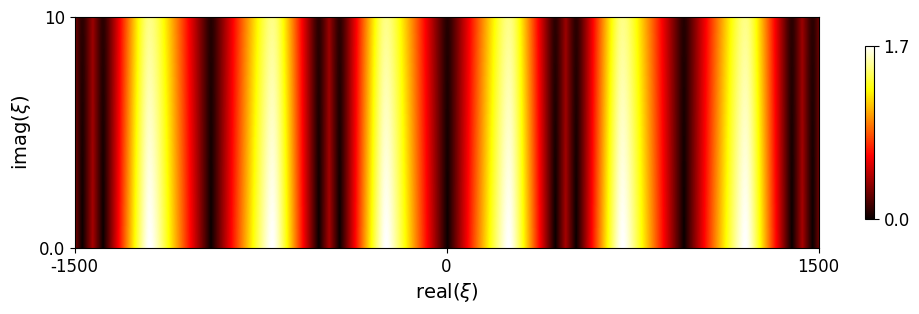

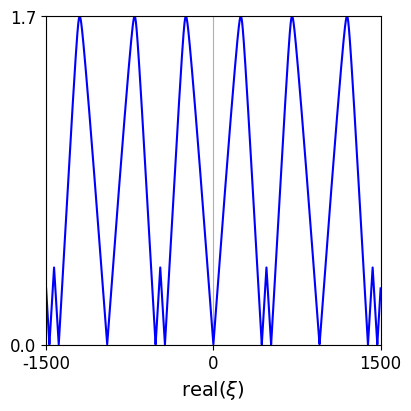

In [179]:
xticks = [ 0, num_f // 2, num_f - 1 ]
yticks = [ 0, num_r - 1 ]
xtick_labels = [ f'{-int(f_max):d}', '0', f'{+int(f_max):d}' ]
ytick_labels = [ '0.0', f'{int(r_max):d}' ]

plt.figure(figsize=(12, 3))
plt.imshow(svmin_Delta_z, origin='lower', vmin=0.0, cmap='hot', aspect='auto')
plt.xlim([ 0, num_f - 1 ])
plt.ylim([ 0, num_r - 1 ])
plt.xticks(xticks, labels=xtick_labels, fontsize=12)
plt.yticks(yticks, labels=ytick_labels, fontsize=12)
plt.xlabel('real($\\xi$)', fontsize=14)
plt.ylabel('imag($\\xi$)', fontsize=14)
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1f}', ticks=[ 0.0, svmin_Delta_z.max() ]).ax.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(4, 4), layout='constrained')
plt.plot(f, svmin_Delta_f, color='b')
plt.xlim([ f.min(), f.max() ])
plt.ylim([ 0.0, svmin_Delta_f.max() ])
plt.xticks([ f.min(), 0, f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([0.0, svmin_Delta_f.max() ], labels=[ '0.0', f'{svmin_Delta_f.max():.1f}'], fontsize=12)
plt.xlabel('real($\\xi$)', fontsize=14)
plt.grid('both')
plt.show()

When $n_e \geq 2n_s$ the set $Z_{\Delta}$ allows us to determine the structure of the solution set as follows. There exists a set $\mathcal{Z}_c$ of measure zero such that for $\boldsymbol{c}_0\notin \mathcal{Z}_c$ we have that for
$$
  Z^*_{\Delta} = \{\eta \in Z_{\Delta}:\,\, \dim\ker(\boldsymbol{\Delta}(\eta)) = n_s\}
$$
the solution set is
$$
  \mathcal{S}(\boldsymbol{s}_0) = \{(\xi_0 + \eta, \boldsymbol{c}_0):\,\,\eta\in Z^*_{\Delta}\}.
$$
The concentrations $\boldsymbol{c}_0\in \mathcal{Z}_c$ can be characterized from the set
$$
  Z^{\circ}_{\Delta} = \{\eta \in Z_{\Delta}:\,\, \dim\ker(\boldsymbol{\Delta}(\eta)) < n_s\}.
$$
Hence, it is useful to determine both $Z^*_{\Delta}$ and $Z^{\circ}_{\Delta}$. When the echo times are commesurable and
$$
  \frac{t_k}{t_{n_e}} = \frac{p_k}{q_k}\quad p_k,q_k\in \mathbb{N}
$$
then we can make a change of variables 
$$
  z = e^{\frac{2\pi i \eta t_{n_e}}{q}}
$$
where
$$
  q = \operatorname{lcm}(\{q_1,\ldots, q_{n_e}\}).
$$
Then, by defining 
$$
  \bar{p}_k = p_k\frac{q}{q_k}
$$
we can write
$$
  \boldsymbol{W}(\eta) = \boldsymbol{W}(z)\quad\text{for}\quad \boldsymbol{W}(z) = \operatorname{diag}(z^{\bar{p}_1},\ldots, z^{\bar{p}_{n_e}}).
$$
Then, for each subset
$$
  S \subset \{1,\ldots n_e\}\quad\text{with}\quad |S| = 2n_s
$$
let $\boldsymbol{\Delta}_S(z)$ be the $2n_s \times 2n_s$ matrix formed with the rows of $\boldsymbol{\Delta}(z)$ with index in $S$. Then, $\det(\boldsymbol{\Delta}_S(z))$ is a polynomial in $z$ and 
$$
  \eta \in Z_{\Delta}\quad\Rightarrow\quad\det(\boldsymbol{\Delta}_S(z)) = 0.
$$
To each such root $z_j$ we can associate an offset $\eta^{\text{offset}}_j$ and the set
$$
  \frac{q}{t_{n_e}} (\eta^{\text{offset}}_j + \mathbb{Z}).
$$
In particular,
$$
  Z_{\Delta} = \bigcup_j \frac{q}{t_{n_e}} (\eta^{\text{offset}}_j + \mathbb{Z}).
$$
As shown $\eta^{\text{offset}}_j$ is real and it follows that this set is also *real*. By computing the common roots of all such polynomials, which is computationally tractable in our case, we obtain a set containing $Z_{\Delta}$. By selecting the roots for which $\ker(\boldsymbol{\Delta}(z))$ is non-trivial we can determine $Z_{\Delta}$ exactly and, by checking the dimension of the nullspace, we can determine $Z_{\Delta}^*$ and $Z_{\Delta}^{\circ}$. Since there is a finite n

In [180]:
from CSITools.routines.roots import find_roots_model

In our code this is done by the function ``find_roots_model``. **This function may return redundant offsets**.

In [181]:
eta_offset, eta_offset_sv, eta_offset_filt, eta_offset_factor = find_roots_model(M, te, peps=1E-3, efactor=5, feps=5E-4, verbose=False)

# save data
np.savez_compressed(f'DAT/E01_SSET_ETA_NE{ne}_NS{ns}.npz', te=te, M=M, eta_offset=eta_offset, eta_offset_sv=eta_offset_sv, eta_offset_filt=eta_offset_filt, eta_offset_factor=eta_offset_factor)

In [182]:
print(f'Summary')
print(f'Global factor : {eta_offset_factor:+.3E}')
print(f'There are {eta_offset.size} generators and {eta_offset_filt.size} filtered generators.')
for _eta, _eta_sv in zip(eta_offset, eta_offset_sv):
  if _eta in eta_offset_filt:
    print(f'  - offset {_eta.real:+.6f} with svmin = {_eta_sv[0]:.3E} and dimker = {_eta_sv[1]:.0f} was kept')
  else:
    print(f'  - offset {_eta.real:+.6f} with svmin = {_eta_sv[0]:.3E} and dimker = {_eta_sv[1]:.0f} was removed')

Summary
Global factor : +2.000E+04
There are 63 generators and 63 filtered generators.
  - offset -0.497906 with svmin = 5.251E-05 and dimker = 1 was kept
  - offset -0.476190 with svmin = 7.132E-05 and dimker = 2 was kept
  - offset -0.454475 with svmin = 6.157E-05 and dimker = 1 was kept
  - offset -0.450287 with svmin = 4.346E-05 and dimker = 1 was kept
  - offset -0.428571 with svmin = 6.418E-05 and dimker = 2 was kept
  - offset -0.406856 with svmin = 7.062E-05 and dimker = 1 was kept
  - offset -0.402668 with svmin = 3.440E-05 and dimker = 1 was kept
  - offset -0.380952 with svmin = 5.705E-05 and dimker = 2 was kept
  - offset -0.359237 with svmin = 7.967E-05 and dimker = 1 was kept
  - offset -0.355049 with svmin = 2.535E-05 and dimker = 1 was kept
  - offset -0.333333 with svmin = 4.992E-05 and dimker = 2 was kept
  - offset -0.311618 with svmin = 8.873E-05 and dimker = 1 was kept
  - offset -0.307430 with svmin = 1.630E-05 and dimker = 1 was kept
  - offset -0.285714 with svm

We can plot the set along with the minimum singular value. 

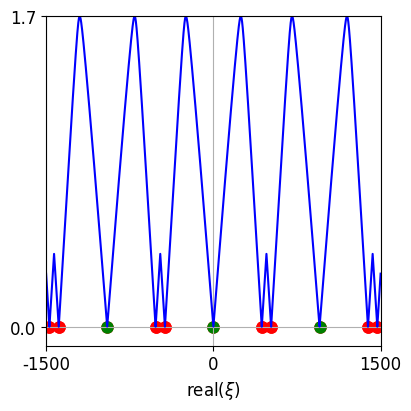

In [183]:
plt.figure(figsize=(4, 4), layout='constrained')
plt.plot(f, svmin_Delta_f, color='b')
for I, _eta in enumerate(eta_offset_filt.ravel()):
  # range
  idx_max = int(np.abs(f_max / eta_offset_factor - _eta.real)) + 1
  _xi = (np.linspace(-idx_max, +idx_max, 2 * idx_max + 1) + _eta.real) * eta_offset_factor
  plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
  # check if dimension is large or not
  idx_eta = np.where(_eta == eta_offset)[0]
  if eta_offset_sv[idx_eta, 1] < ns:
    plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
  else:
    plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='g')
plt.xlim([ f.min(), f.max() ])
plt.ylim([ -0.1, svmin_Delta_f.max() ])
plt.xticks([ f.min(), 0, f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([0.0, svmin_Delta_f.max() ], labels=[ '0.0', f'{svmin_Delta_f.max():.1f}'], fontsize=12)
plt.xlabel('real($\\xi$)', fontsize=12)
plt.grid('both')
plt.show()

One of the most important aspects of this set is the smallest magnitude among its non-zero elements.

In [184]:
dmin = np.inf
for _eta in eta_offset:
  _dmin = eta_offset_factor * (np.abs(_eta) - np.round(np.abs(_eta)))
  if _dmin > 0:
    dmin = np.min([ dmin, _dmin ])
print(f'Distance to zero : {dmin:.3f} Hz')

Distance to zero : 434.320 Hz


## Swaps

For this point we can determine the swaps, i.e., the directions that allow the exchange in concentrations. 

In [185]:
# matrix
Delta_x = Delta(dmin)
# svd
[ Ux, Sx, Vx ] = np.linalg.svd(Delta_x)

print(f'Singular values and vector at {dmin:.3f}')
for _sx, _vx in zip(Sx, Vx):
  if _sx < 1E-2:
    with np.printoptions(precision=6, suppress=True):
      print(f'Singular value : {_sx:.4E}')
      print('   Change in 1st species :', +_vx[:ns])
      print('   Change in 2nd species :', -_vx[ns:])

Singular values and vector at 434.320
Singular value : 3.8026E-05
   Change in 1st species : [0.000005+0.j       0.00596 -0.707082j]
   Change in 2nd species : [ 0.005909-0.707082j -0.000005-0.j      ]


## Figures

### Solution set when the true concentrations are known

Water and fat and water, fat and silicone.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


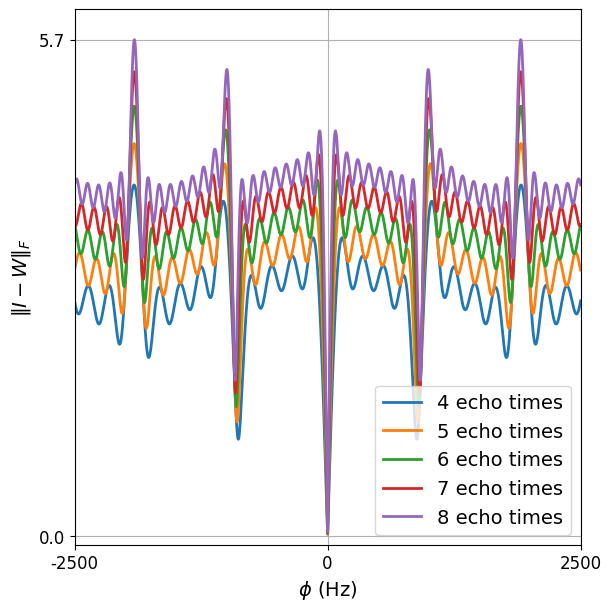

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


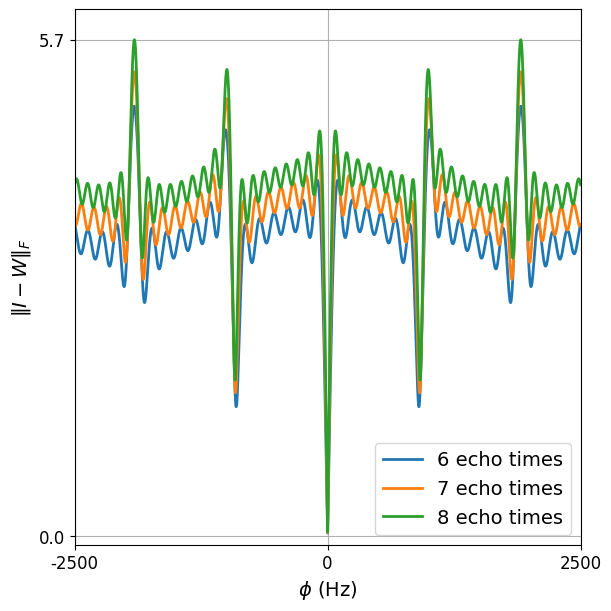

In [186]:
_Ef_max = -np.inf

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
for I, Ie in enumerate([ 4, 5, 6, 7, 8 ]):
  # filename
  fname = f'DAT/E01_E_FULL_NE{Ie}_NS{2}.npz'
  # load data
  _f = np.load(fname)['f']
  _Ef = np.load(fname)['Ef']
  _Ef_max = np.maximum(_Ef_max, _Ef.max())

  xtick_labels = [ f'{-int(_f.max()):d}', '0', f'{+int(_f.max()):d}' ]

  plt.plot(_f, _Ef, linewidth=2, color=cm['tab10'](I), label=f'{Ie} echo times')
plt.xlim([ _f.min(), _f.max() ])
plt.ylim([ -0.1, np.ceil(_Ef_max) ])
plt.xticks([ _f.min(), 0, _f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([ 0.0, _Ef_max ], labels=[ '0.0', f'{_Ef_max.max():.1f}'], fontsize=12)
plt.xlabel('$\\phi$ (Hz)', fontsize=14)
plt.ylabel('$\|I - W\|_F$', fontsize=14)
plt.grid('both')
plt.legend(loc='lower right', fontsize=14)

savefig('WSET_WF')

plt.show()

_Ef_max = -np.inf

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
for I, Ie in enumerate([ 6, 7, 8 ]):
  # filename
  fname = f'DAT/E01_E_FULL_NE{Ie}_NS{3}.npz'
  # load data
  _f = np.load(fname)['f']
  _Ef = np.load(fname)['Ef']
  _Ef_max = np.maximum(_Ef_max, _Ef.max())

  xtick_labels = [ f'{-int(_f.max()):d}', '0', f'{+int(_f.max()):d}' ]

  plt.plot(_f, _Ef, linewidth=2, color=cm['tab10'](I), label=f'{Ie} echo times')
plt.xlim([ _f.min(), _f.max() ])
plt.ylim([ -0.1, np.ceil(_Ef_max) ])
plt.xticks([ _f.min(), 0, _f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([0.0, _Ef_max ], labels=[ '0.0', f'{_Ef_max.max():.1f}'], fontsize=12)
plt.xlabel('$\\phi$ (Hz)', fontsize=14)
plt.ylabel('$\|I - W\|_F$', fontsize=14)
plt.grid('both')
plt.legend(loc='lower right', fontsize=14)

savefig('WSET_WFS')

plt.show()

### Structure of the solution set

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


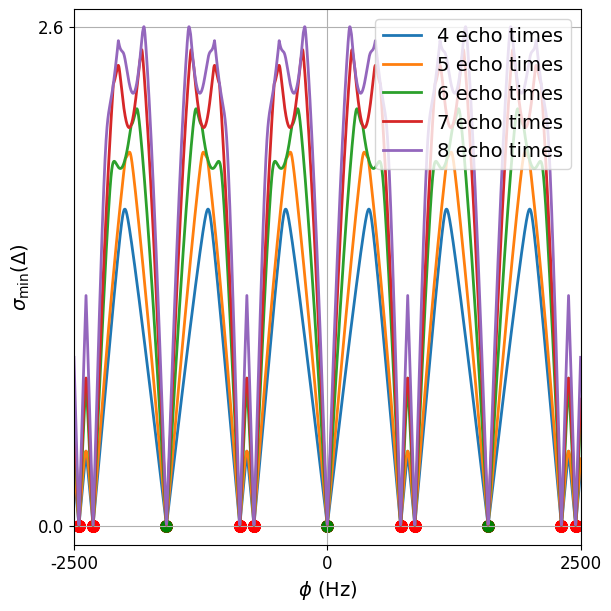

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


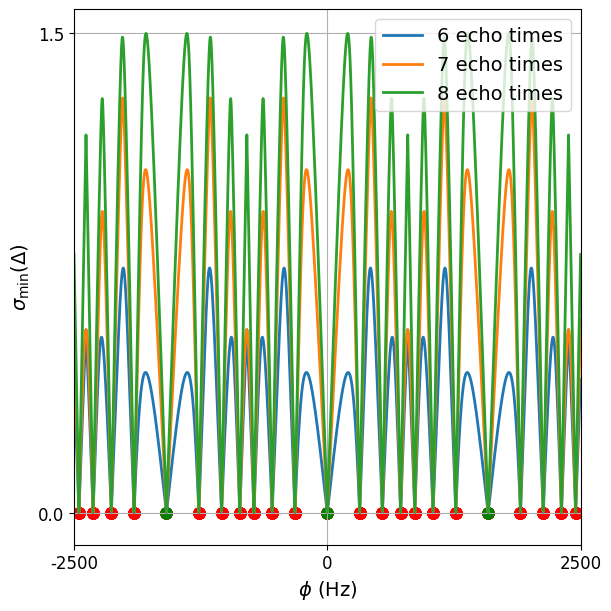

In [188]:
_svmin_Delta_f_max = -np.inf

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
for I, Ie in enumerate([ 4, 5, 6, 7, 8 ]):
  # filename
  fname = f'DAT/E01_SVMIN_DELTA_NE{Ie}_NS{2}.npz'
  # load data
  _f = np.load(fname)['f']
  _svmin_Delta_f = np.load(fname)['svmin_Delta_f']
  _svmin_Delta_f_max = np.maximum(_svmin_Delta_f_max, _svmin_Delta_f.max())

  # filename
  fname = f'DAT/E01_SSET_ETA_NE{ne}_NS{2}.npz'
  # load data
  _eta_offset = np.load(fname)['eta_offset']
  _eta_offset_filt = np.load(fname)['eta_offset_filt']
  _eta_offset_factor = np.load(fname)['eta_offset_factor']
  _eta_offset_sv = np.load(fname)['eta_offset_sv']
  for _eta in _eta_offset_filt.ravel():
    # range
    idx_max = int(np.abs(_f.max() / _eta_offset_factor - _eta.real)) + 1
    _xi = (np.linspace(-idx_max, +idx_max, 2 * idx_max + 1) + _eta.real) * _eta_offset_factor
    plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
    # check if dimension is large or not
    idx_eta = np.where(_eta == _eta_offset)[0]
    if _eta_offset_sv[idx_eta, 1] < 2:
      plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
    else:
      plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='g')

  plt.plot(_f, _svmin_Delta_f, linewidth=2, color=cm['tab10'](I), label=f'{Ie} echo times')
plt.xlim([ _f.min(), _f.max() ])
plt.ylim([ -0.1, np.ceil(10 * _svmin_Delta_f_max) / 10 ])
plt.xticks([ _f.min(), 0, _f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([0.0, _svmin_Delta_f_max ], labels=[ '0.0', f'{_svmin_Delta_f_max.max():.1f}'], fontsize=12)
plt.xlabel('$\\phi$ (Hz)', fontsize=14)
plt.ylabel('$\\sigma_{\\min}(\\Delta)$', fontsize=14)
plt.grid('both')
plt.legend(loc='upper right', fontsize=14)

savefig('SSET_WF')

plt.show()

_svmin_Delta_f_max = -np.inf

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
for I, Ie in enumerate([ 6, 7, 8 ]):
  # filename
  fname = f'DAT/E01_SVMIN_DELTA_NE{Ie}_NS{3}.npz'
  # load data
  _f = np.load(fname)['f']
  _svmin_Delta_f = np.load(fname)['svmin_Delta_f']
  _svmin_Delta_f_max = np.maximum(_svmin_Delta_f_max, _svmin_Delta_f.max())

  # filename
  fname = f'DAT/E01_SSET_ETA_NE{Ie}_NS{3}.npz'
  # load data
  _eta_offset = np.load(fname)['eta_offset']
  _eta_offset_filt = np.load(fname)['eta_offset_filt']
  _eta_offset_factor = np.load(fname)['eta_offset_factor']
  _eta_offset_sv = np.load(fname)['eta_offset_sv']
  for _eta in _eta_offset_filt.ravel():
    # range
    idx_max = int(np.abs(_f.max() / _eta_offset_factor - _eta.real)) + 1
    _xi = (np.linspace(-idx_max, +idx_max, 2 * idx_max + 1) + _eta.real) * _eta_offset_factor
    plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
    # check if dimension is large or not
    idx_eta = np.where(_eta == _eta_offset)[0]
    if _eta_offset_sv[idx_eta, 1] < 3:
      plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='r')
    else:
      plt.scatter(_xi, np.zeros(_xi.shape), s=64, color='g')

  plt.plot(_f, _svmin_Delta_f, linewidth=2, color=cm['tab10'](I), label=f'{Ie} echo times')
plt.xlim([ _f.min(), _f.max() ])
plt.ylim([ -0.1, np.ceil(10 * _svmin_Delta_f_max) / 10 ])
plt.xticks([ _f.min(), 0, _f.max() ], labels=xtick_labels, fontsize=12)
plt.yticks([ 0.0, _svmin_Delta_f_max ], labels=[ '0.0', f'{_svmin_Delta_f_max.max():.1f}'], fontsize=12)
plt.xlabel('$\\phi$ (Hz)', fontsize=14)
plt.ylabel('$\\sigma_{\\min}(\\Delta)$', fontsize=14)
plt.grid('both')
plt.legend(loc='upper right', fontsize=14)

savefig('SSET_WFS')

plt.show()